# Example of usage of AdaBKB

In [1]:
import numpy as np

from adabkb import AdaBKB
from adabkb.options import OptimizerOptions
from sklearn.gaussian_process.kernels import RBF

import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import RandomState

## Target function: Branin

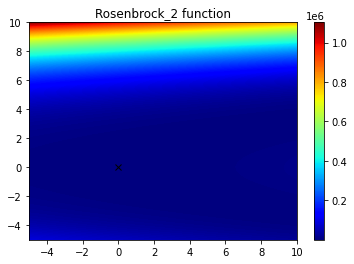

In [2]:
from benchmark_functions import Branin

def plot_fun(x1 : np.ndarray, x2 : np.ndarray, fun):
    X = np.zeros((x1.shape[0], x2.shape[0]), dtype=np.float64, order="C")
    for i in range(x1.shape[0]):
        for j in range(x2.shape[0]):
            X[i,j] = fun(np.array([x1[i], x2[j]]))
    fig, ax = plt.subplots()
    ax.set_title("%s function" % fun.name)
    c = ax.imshow(X, cmap='jet', vmin=X.min(), vmax = X.max(),
              extent=[x1.min(), x1.max(), x2.min(), x2.max()],
              interpolation='gaussian', origin='lower', aspect='auto')
    gmins = np.array(fun.global_min[0]).reshape(-1, 2)
    ax.plot(gmins[:, 0], gmins[:, 1], 'x', c='black', label="real optimizer")
    fig.colorbar(c, ax=ax)
    return fig, ax
fun = Branin((0.5, RandomState(42)))
x1 = np.linspace(fun.search_space[0][0], fun.search_space[0][1], 400).reshape(-1)
x2 = np.linspace(fun.search_space[1][0], fun.search_space[1][1], 400).reshape(-1)
fig, ax = plot_fun(x1, x2, fun)

In [3]:
def is_in(x, lst):
    for y in lst:
        if np.all(x == y):
            return True
    return False

sigma = 1.0
lam = 1e-9
N = 3
v1 = 2 * np.sqrt(N)
rho = N**(-1/2)
gfun = lambda x: (1/sigma) * x 
options = OptimizerOptions(gfun, v_1=v1, rho=rho, lam=lam, fnorm=1.0,\
     noise_var=lam**2, verbose=True)
opt = AdaBKB(RBF(sigma), options)
T = 100
t = 0
h_max = 10
opt.initialize(fun.search_space, N, h_max = h_max)
#print("root: ",fun.search_space.mean(axis=1))
eval_x = []
reg = []
lfset_size = []
root = fun.search_space.mean(axis=1)
ax.plot(root[0], root[1], 'o', c='red', label="root")
while t <= T:
    xt, ind = opt.step()
    if not is_in(xt, eval_x):
        eval_x.append(xt)
    yt = -fun(xt)
    lfset_size.append(len(opt.leaf_set))
    reg.append(-yt - fun.global_min[1])
    if ind is None:
        break
    opt.update_model(ind, yt)
    t+=1
reg = np.cumsum(reg)
reg = [reg[i]/(i+1) for i in range(len(reg))]
print("[--] Best x: {} => {}".format(opt.current_best[0].x, fun(opt.current_best[0].x)))
xb = opt.current_best[0].x
yb = fun(xb)
eval_x = np.array(eval_x).reshape(-1,2)



[--] update completed in 0.004254 seconds.
[--] update completed in 0.012430 seconds.
[--] update completed in 0.017082 seconds.
[--] update completed in 0.004146 seconds.
[--] update completed in 0.012216 seconds.
[--] update completed in 0.004040 seconds.
[--] update completed in 0.003844 seconds.
[--] update completed in 0.009083 seconds.
[--] update completed in 0.007216 seconds.
[--] update completed in 0.005983 seconds.
[--] update completed in 0.005070 seconds.
[--] update completed in 0.019914 seconds.
[--] update completed in 0.008776 seconds.
[--] update completed in 0.004917 seconds.
[--] update completed in 0.006992 seconds.
[--] update completed in 0.005699 seconds.
[--] update completed in 0.006666 seconds.
[--] update completed in 0.007819 seconds.
[--] update completed in 0.008536 seconds.
[--] update completed in 0.015539 seconds.
[--] update completed in 0.014345 seconds.
[--] update completed in 0.011608 seconds.
[--] update completed in 0.012576 seconds.
[--] update

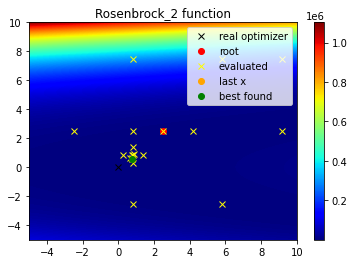

In [4]:
ax.plot(eval_x[:,0], eval_x[:, 1], 'x', color="yellow", label="evaluated")
ax.plot(xt[0], xt[1], 'o', color="orange", label="last x")
ax.plot(xb[0], xb[1], 'o', color="green", label="best found")
ax.legend(loc="upper right")
fig




Text(0, 0.5, 'average regret')

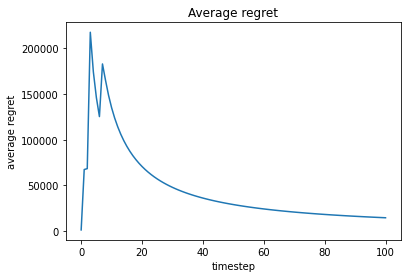

In [5]:
plt.close(fig)
fig,ax = plt.subplots()
ax.set_title("Average regret")
ax.plot(range(len(reg)), reg, '-', label="adabkb")
ax.set_xlabel("timestep")
ax.set_ylabel("average regret")

Text(0, 0.5, 'leaf set size')

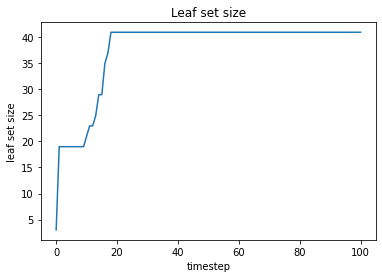

In [6]:
plt.close(fig)
fig,ax = plt.subplots()
ax.set_title("Leaf set size")
ax.plot(range(len(lfset_size)), lfset_size, '-', label="adabkb")
ax.set_xlabel("timestep")
ax.set_ylabel("leaf set size")